In [235]:
import os, sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn 
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm import *
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
rawdataPath = os.path.join(os.path.abspath(".."),"rawdata")
rootPath = os.getcwd()
dataPath = os.path.join(rootPath,"data")
modelPath = os.path.join(rootPath,"model")

In [237]:
if not os.path.exists(dataPath):
    os.makedirs(dataPath)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

In [238]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"available processor is {device}")

available processor is cuda


In [239]:
raw_train = pd.read_csv(os.path.join(rawdataPath,"train.csv"), dtype=np.float32)
X_numpy = raw_train.loc[:,raw_train.columns != "label"].values/255 # normalization
y_numpy = raw_train.label.values
X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
y_tensor = torch.tensor(y_numpy, dtype=torch.int64)


X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)
X_train = X_train.to(device=device)
X_val = X_val.to(device=device)
X_test = X_test.to(device=device)
y_train = y_train.to(device=device)
y_val = y_val.to(device=device)
y_test = y_test.to(device=device)

In [240]:
batch_size = 32
train_td = TensorDataset(X_train, y_train)
val_td = TensorDataset(X_val, y_val)
test_td = TensorDataset(X_test, y_test)
train_dl = DataLoader(train_td, batch_size, shuffle = True)
val_dl = DataLoader(val_td, batch_size, shuffle = False)
test_dl = DataLoader(test_td, len(test_td), shuffle=False)

In [241]:
class Ann(torch.nn.Module):
    def __init__(self):
        super(Ann, self).__init__()
        self.input_layer = torch.nn.Sequential(
                torch.nn.Linear(784,1024),
            )
        
        self.hidden_layer1 = torch.nn.Sequential(
            torch.nn.Linear(1024,512),
            torch.nn.Sigmoid(),
        )
        
        self.hidden_layer2 = torch.nn.Sequential(
            torch.nn.Linear(512,128),
            torch.nn.ReLU(),
        )
        
        self.hidden_layer3 = torch.nn.Sequential(
            torch.nn.Linear(128,32),
            torch.nn.ReLU(),
        )
        
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(32,10)
        )
        self.optimizer = None
        self.loss_fn = None
        
    def forward(self, input) -> torch.Tensor:
        input = input.view(-1,28 * 28)
        input_layer = self.input_layer(input)
        hidden_layer1 = self.hidden_layer1(input_layer)
        hidden_layer2 = self.hidden_layer2(hidden_layer1)
        hidden_layer3 = self.hidden_layer3(hidden_layer2)
        output = self.output_layer(hidden_layer3)
        return output

ann = Ann().to(device=device)
#It already self-initiated the weighted matrix

In [242]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train() #set the model into training mode.
    prediction = model(x)
    batch_loss = loss_fn(prediction,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [243]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # change into the evaluation mode
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = (argmaxes == y)
    return is_correct.cpu().detach().numpy().tolist()

<p>
    We should better choose the epoch time = 5 to avoid overfitting 
    <img src="https://github.githubassets.com/images/icons/emoji/unicode/1f37a.png?v8" alt="Beer Emoji">
    <div>Then is hypertuning</div>
</p>

Overall Progress, epoch number for learning rate 0.01:   0%|          | 0/15 [00:00<?, ?it/s]

Overall Progress, epoch number for learning rate 0.01: 100%|██████████| 15/15 [00:37<00:00,  2.52s/it]
Overall Progress, epoch number for learning rate 0.001: 100%|██████████| 15/15 [00:43<00:00,  2.90s/it]
Overall Progress, epoch number for learning rate 0.0001: 100%|██████████| 15/15 [00:43<00:00,  2.87s/it]


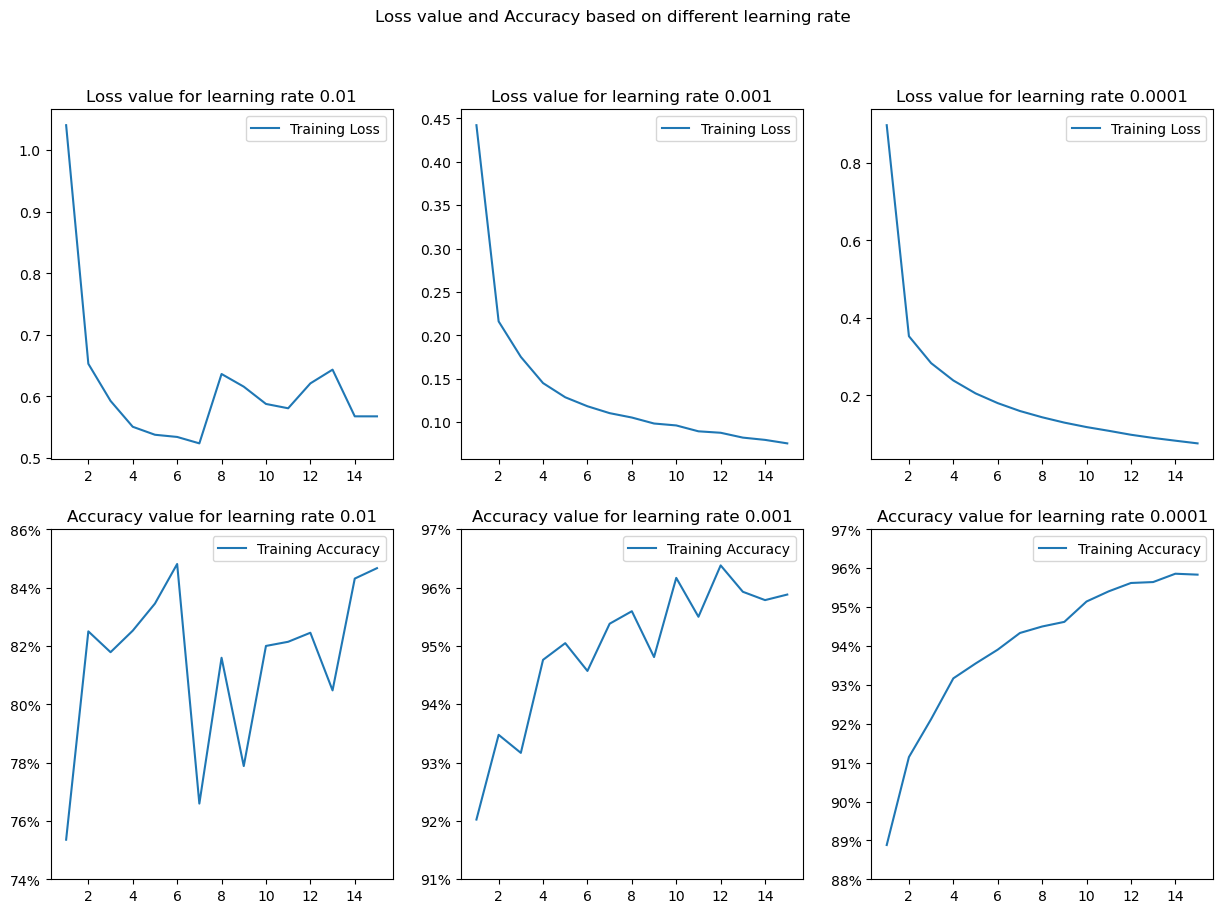

In [244]:
ann_list = []
epoch_time = 15
lr_list = [1e-2, 1e-3, 1e-4]
epochs = np.arange(epoch_time)+1   
subplot_size = 5
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(3*subplot_size, 2*subplot_size))
loss_list, val_accuracy_list, test_accuracy_list = [], [], []
def plot(j):
    axes[0, j].plot(epochs, losses, label='Training Loss')
    axes[0, j].set_title(f'Loss value for learning rate {lr_list[j]}')
    axes[0, j].legend()
    axes[1, j].plot(epochs, val_accuracies, label='Training Accuracy')
    axes[1, j].set_title(f'Accuracy value for learning rate {lr_list[j]}')
    current_ticks = axes[1, j].get_yticks()
    axes[1, j].set_yticks(current_ticks)
    axes[1, j].set_yticklabels(['{:.0f}%'.format(x*100) for x in current_ticks])    
    axes[1, j].legend()

for j in range(len(lr_list)):
    ann = Ann().to(device=device)
    ann.optimizer = optim.Adam(ann.parameters(),lr = lr_list[j])
    ann.loss_fn = nn.CrossEntropyLoss()
    losses, val_accuracies = [], []

    with tqdm(total=epoch_time, desc = f"Overall Progress, epoch number for learning rate {lr_list[j]}") as pbar:
        for epoch in range(epoch_time):
            epoch_losses, val_epoch_accuracies = [], []

            # Inner progress bar for batches within the epoch
            for ix, batch in tqdm(enumerate(iter(train_dl)), total=len(train_dl), desc=f"Epoch {epoch+1}", leave=False):
                x, y = batch
                batch_loss = train_batch(model=ann, x=x, y=y, optimizer=ann.optimizer, loss_fn=ann.loss_fn)
                epoch_losses.append(batch_loss)
                

            epoch_loss = np.array(epoch_losses).mean()
            losses.append(epoch_loss)
            
            # Optionally, you can use another progress bar for the accuracy computation
            for ix, batch in tqdm(enumerate(iter(val_dl)), total=len(val_dl), desc=f"Accuracy Epoch {epoch+1}", leave=False):
                x, y = batch
                is_correct = accuracy(x, y, ann)
                val_epoch_accuracies.extend(is_correct)

            epoch_accuracy = np.mean(val_epoch_accuracies)
            val_accuracies.append(epoch_accuracy)
            pbar.update(1)
            


    plot(j)
    
    loss_list.append(losses)
    val_accuracy_list.append(val_accuracies)
    ann_list.append(ann)
    
    for ix, batch in tqdm(enumerate(iter(test_dl)), total=len(test_dl), desc=f"Accuracy Epoch {epoch+1}", leave=False):
        x, y = batch
        is_correct = accuracy(x, y, ann)
        test_accuracy_list.append(np.mean(is_correct))

plt.suptitle("Loss value and Accuracy based on different learning rate")
plt.show()

In [249]:
test_accuracy_list
#based on the graph and smoothness, I will choose the model with learning rate 1e-4

[0.8433333333333334, 0.9547619047619048, 0.9597619047619048]

So I prefer epoch_times = 15 and learning rate with 1e-4 here

Then here is my prediction for the test dataset and check for the accuracy

Submission for the Kaggle <img src = "https://github.githubassets.com/images/icons/emoji/unicode/1f37b.png?v8" alt = "beer"></img>

In [250]:
for dirpath, dirnames, filenames in os.walk(rawdataPath):
    print(f"Found directory: {dirpath}")
    for file_name in filenames:
        print(f"--->{file_name}")

Found directory: c:\Users\guoyy\OneDrive\Desktop\computer vision\HW\rawdata
--->test.csv
--->train.csv


In [259]:
testraw = pd.read_csv(os.path.join(rawdataPath,"test.csv"), sep=",")
testraw = testraw.values / 255.0
testraw = torch.tensor(testraw, dtype= torch.float32).to(device=device)

In [266]:
@torch.no_grad()
def predict(x, model):
    model.eval()
    prediction = model(x)
    maxvalues, argmax = prediction.max(-1)
    prediction = argmax.cpu().detach().numpy()
    return prediction

In [270]:
pd.Series(np.arange(1,28001))

0            1
1            2
2            3
3            4
4            5
         ...  
27995    27996
27996    27997
27997    27998
27998    27999
27999    28000
Length: 28000, dtype: int32

In [273]:
model = ann_list[2]
prediction = predict(testraw,model)
submission = pd.DataFrame({
    "ImageId" : pd.Series(np.arange(1,28001)),
    "Label" :  prediction
})
submission.to_csv(os.path.join(dataPath,"ann_prediction.csv"), sep=",", index=False)